<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L33-GraphAttentionNetworks-CiteSeer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Netwotks (GAT)
## Node Classification

We will use a new popular dataset for node classification called **CiteSeer** (MIT License). Like **Cora**, it represents a network of research papers where each connection is a citation. **CiteSeer** involves **3327** nodes, whose features represent the presence (1) or absence (0) of **3703** words in a paper. The goal of this dataset is to correctly classify these nodes into six categories. Plot of **CiteSeer** made with yEd Live:

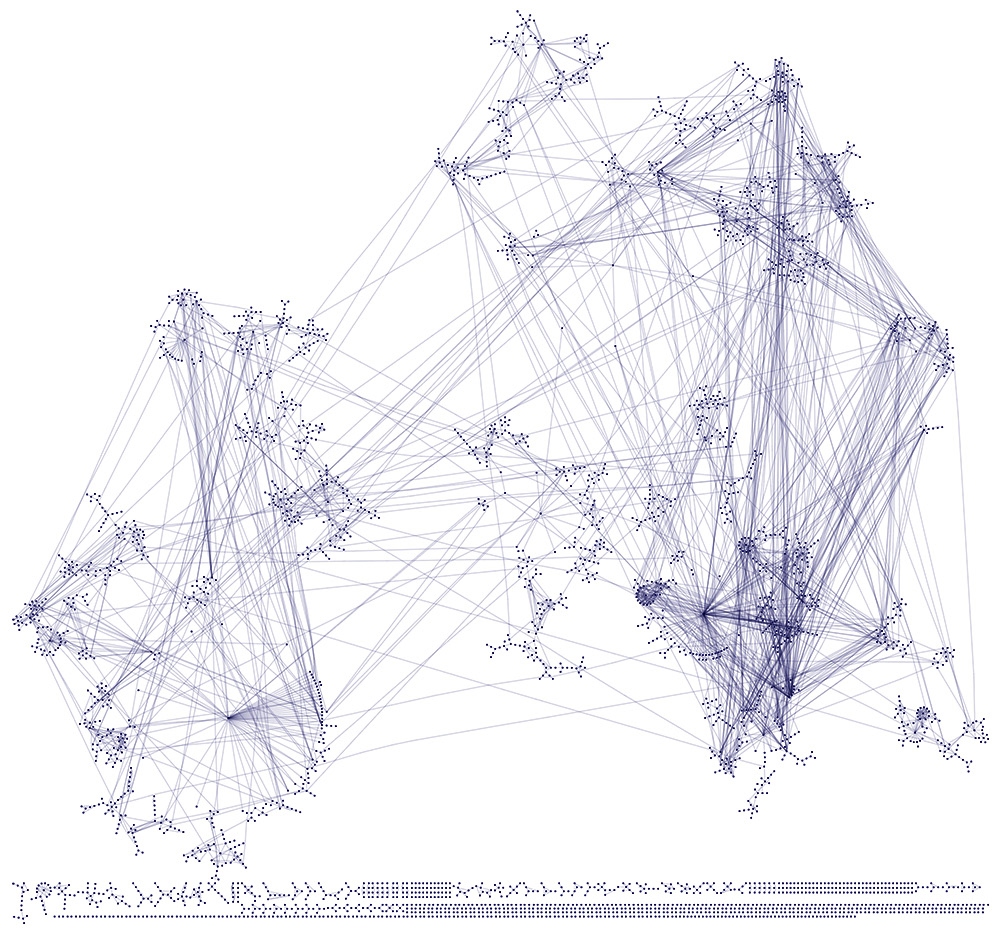

Compared to **Cora**, this dataset is larger in terms of the number of nodes (from 2,708 to 3,327) and also in terms of feature dimensionality (from 1,433 to 3,703). However, the exact same process can be applied to it:

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


We import the necessary libraries to create our own GAT class, using the GATv2 layer:

In [6]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import degree
from collections import Counter

from torch_geometric.datasets import Planetoid

We implement the `accuracy()` function to evaluate the performance of our model:

In [4]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

### Load dataset

In [7]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

### Visualizing Graph

In [ ]:
# plot graph...

For good measure, we plot the number of nodes per node degree...

<BarContainer object of 32 artists>

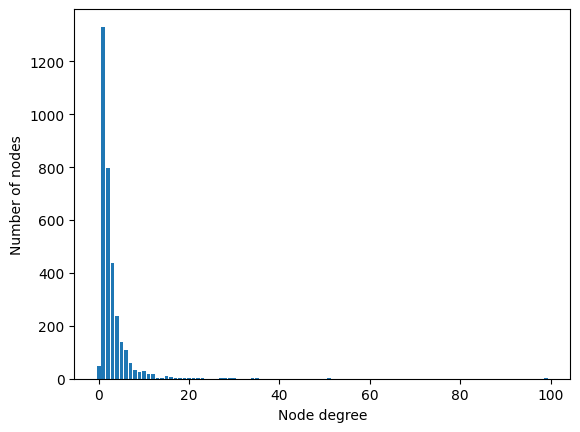

In [8]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

### Build GAT model

In [ ]:
# GAT class ...
class GAT...

In [ ]:
# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat)

In [ ]:
# Train
gat.fit(data, epochs=100)

In [ ]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

### Check hypothesis

Is it a good result? This time, we have no point of comparison.

According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better than the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ± 0.9%). The authors also note that the accuracy scores are not normally distributed, making the usage of standard deviation less relevant. It is important to keep that in mind in this type of benchmark.

Previously, I speculated that poorly connected nodes might negatively impact performance. We can verify this hypothesis by plotting the average accuracy score for each node degree:

We get the model’s classifications:

In [ ]:
# Get model's classifications
out = gat(data.x, data.edge_index)

We calculate the degree of each node

In [ ]:
# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()


We store the accuracy scores and sample sizes

In [ ]:
# Store accuracy scores and sample sizes
accuracies = []
sizes = []

We get the average accuracy for each node degree between zero and five using a mask with np.where():

In [ ]:
# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

We repeat this process for every node with a degree higher than five

In [ ]:
# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

It outputs the following graph

In [ ]:
# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

Our result must be like this:

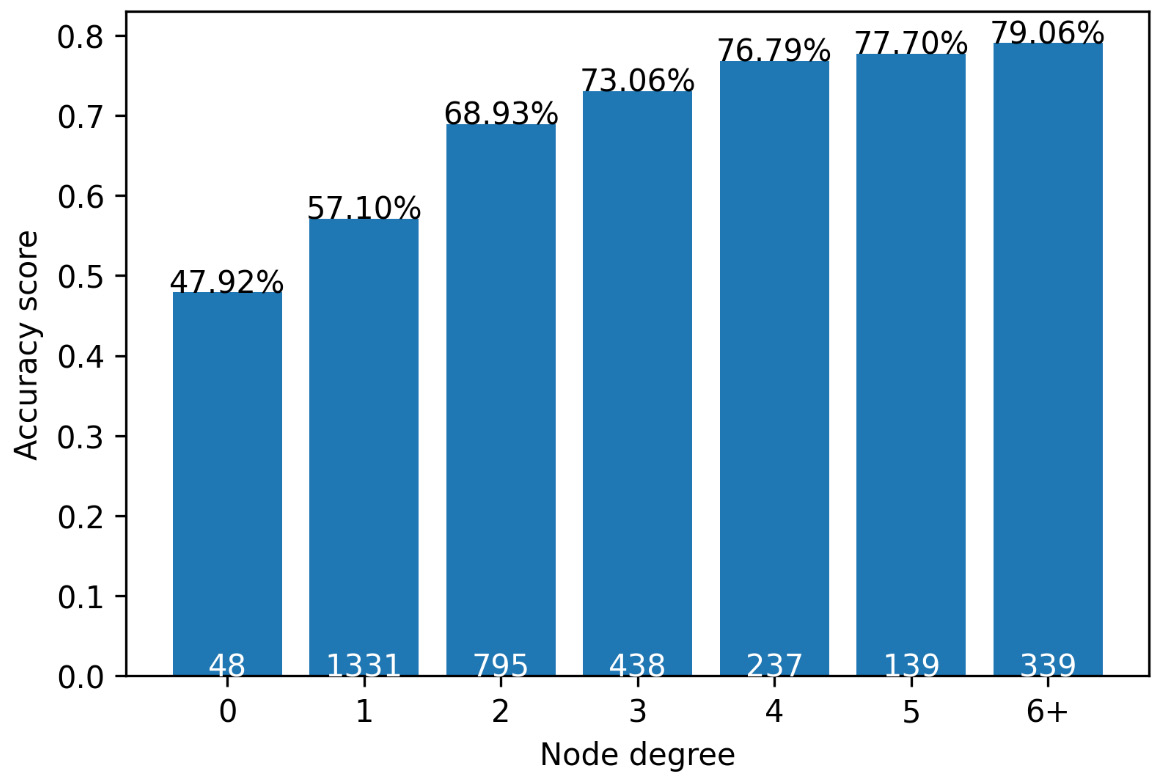

Confirms our hypothesis: nodes with few neighbors are harder to classify correctly. Furthermore, it even shows that, in general, the higher the node degree, the better the accuracy score. This is quite natural because a higher number of neighbors will provide more information to the GNN to make its predictions.